In [18]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from landaupy import langauss
from landaupy import landau
from scipy.optimize import curve_fit
from scipy.optimize import OptimizeWarning
from tqdm import tqdm
import warnings
from scipy.stats import chisquare
import sys
sys.path.append("../src")
from event_selections import *
from scipy.integrate import quad
from scipy.integrate import IntegrationWarning

In [60]:
c_folder="../../data/calibration"
d_folder="../../data/runData"
r_n=300
pulsed=False
p_folder="../../plots/run_"+str(r_n)

In [61]:
def choose_bar(df,layer, strip):
    df=df[df["strip"]==strip]
    df=df[df["layer"]==layer]
    return df

def drop_columns(df):
    kept_columns=['layer', 'strip', 'pedestal', 'pf_event', 'adc_sum_end0', 'adc_sum_end1', 'end', 'mpv', 'std_dev', 'tot_end0', 'tot_end1']
    df=df[df.columns.intersection(kept_columns)]
    return df

def import_data(calibration_folder, data_folder, run_n):
    pedestals=drop_columns(pd.read_csv(calibration_folder+"/pedestals_MIP.csv", sep=','))
    mips=drop_columns(pd.read_csv(calibration_folder+"/mip.csv", sep=','))
    run=drop_columns(pd.read_csv(data_folder+"/run_"+str(run_n)+".csv", sep=','))
    run=run.astype({"adc_sum_end0":float,"adc_sum_end1":float}) 
    return pedestals,mips,run

In [62]:
p,m,r= import_data(c_folder,d_folder,r_n)

In [63]:
def confirm_events_sigma(df, pedestals, mips):
    # signal defined as anything above pedestal+5*pedestal std_dev
    confirmed_data=[]
    layers=np.arange(1,20)
    strips=np.arange(0,12)
    for layer in layers:
        for strip in strips:
            df_slice=choose_bar(df,layer,strip)
            pedestal_slice=choose_bar(pedestals,layer,strip)
            mip=choose_bar(mips,layer,strip)
            if not pedestal_slice.empty:
                df_slice=df_slice[df_slice["adc_sum_end0"]>(pedestal_slice.iloc[0,-2]+5*pedestal_slice.iloc[0,-1])] 
                df_slice=df_slice[df_slice["adc_sum_end1"]>(pedestal_slice.iloc[1,-2]+5*pedestal_slice.iloc[0,-1])] 

                df_slice.loc[:,"adc_sum_end0"]-=pedestal_slice.iloc[0,-2] # subtracting pedestals
                df_slice.loc[:,"adc_sum_end1"]-=pedestal_slice.iloc[1,-2]

                df_slice.loc[:,"adc_sum_end0"]*=(4.66/mip.iloc[0,-1]) # converting to energy
                df_slice.loc[:,"adc_sum_end1"]*=(4.66/mip.iloc[1,-1])
                
            confirmed_data.extend(df_slice.values.tolist())
    confirmed_df=pd.DataFrame(confirmed_data, columns=['event','tot_end0', 'adc_sum_end0', 'layer', 'strip', 'tot_end1','adc_sum_end1'])
    events_left=confirmed_df.event.unique()
    print("Initial pedestal-based selection performed.")
    print("Events left: "+str(len(events_left)))
    print("\n")
    return confirmed_df

In [64]:
def landau_fit(x,A,x_mpv,xi):
    return A*landau.pdf(x=x,x_mpv=x_mpv, xi=xi)

In [65]:
runData=confirm_events_sigma(r,p,m)

Initial pedestal-based selection performed.
Events left: 71415




In [74]:
runData.head()

,event,tot_end0,adc_sum_end0,layer,strip,tot_end1,adc_sum_end1
0,341.0,0.0,1.500580,1.0,0.0,0.0,1.418696
1,444.0,0.0,0.711386,1.0,0.0,0.0,2.067556
2,501.0,0.0,1.456118,1.0,0.0,0.0,1.385703
3,766.0,0.0,0.655809,1.0,0.0,0.0,0.560880
4,878.0,656.0,46.306773,1.0,0.0,384.0,30.056549


In [38]:
possible_A=np.arange(2000,100000,100)
possible_xi=np.arange(0.01,10,0.01)
possible_x0=np.arange(0.5,5,0.2)

In [42]:
print(len(possible_A))
print(len(possible_xi))
print(len(possible_x0))

980
999
23


In [39]:
len(possible_A)*len(possible_xi)*len(possible_x0)

22517460

In [92]:
time_cont=np.arange(0,8,0.1)
data=[]
for A in tqdm(possible_A[-2:-1]):
    for xi in possible_xi[:100]:
        for x0 in possible_x0:
            pulse=landau_fit(time_cont,A,x0,xi)
            integral, _ = quad(landau_fit, 0,7, (A,x0,xi), limit=100)
            TOT=round(sum(pulse>1023)*0.1*25*20)
            sumADC=round(integral)
            line=[sumADC,TOT]
            data.append(line)

100%|█████████████████████████████████████████████| 1/1 [01:14<00:00, 74.88s/it]


In [93]:
calib_df=pd.DataFrame(data, columns=["sumADC", "TOT"])

<Axes: xlabel='sumADC', ylabel='TOT'>

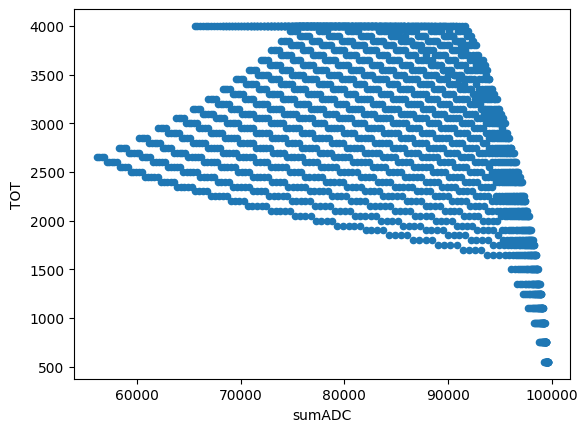

In [97]:
calib_df.plot.scatter("sumADC", "TOT")